# import library

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from tqdm.auto import tqdm

In [2]:
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
print(torch.__version__)

1.8.0


In [4]:
print(np.__version__)

1.23.1


# set pytorch gpu

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# notation

## bit definitions

In [6]:
%%html
<style>
table {float:left}
</style>

| box_value | box_name     |
|-----------|--------------|
| 0         | Empty        |
| 1         | BrownWood    |
| 2         | RedWood      |
| 3         | GreenWood    |
| 4         | BrownLeather |
| 5         | BrownPaper   |
| 6         | BlueSteel    |

# environment

In [7]:
class MoveTheBoxGameEnvironment:
    def __init__(
        self,
        board_height=9,
        board_width=7,
        unique_box_type=6,
        p_add_3_box=0.77,
        debug=False,
    ):

        # init parameter
        self.board_height = board_height
        self.board_width = board_width
        self.unique_box_type = unique_box_type
        self.p_add_3_box = p_add_3_box
        self.debug = debug

        # init color_map
        box_color_map_list = (
            np.array(
                [
                    [255, 255, 255],
                    [169, 133, 92],
                    [183, 71, 34],
                    [156, 164, 52],
                    [102, 65, 38],
                    [189, 140, 61],
                    [149, 165, 168],
                ]
            )
            / 255
        )
        self.box_color_map = LinearSegmentedColormap.from_list(
            "box_color_map",
            box_color_map_list,
            box_color_map_list.shape[0],
        )

        # init game
        self.reset()

    def reset(self):
        self.cumulative_score = 0
        self.createBoard()
        self.createAboveBoard()
        self.addAboveBox()
        self.aboveIncludeFall()

    def createBoard(self):
        self.board = np.zeros(
            (self.board_height, self.board_width),
            dtype=np.int8,
        )

    def createAboveBoard(self):
        self.above_board = np.zeros(
            (1, self.board_width),
            dtype=np.int8,
        )

    def addAboveBox(self):
        number_of_box_above = np.random.choice(
            [3, 4], p=[self.p_add_3_box, 1 - self.p_add_3_box]
        )
        box_value = np.random.randint(
            low=1,
            high=self.unique_box_type + 1,
            size=number_of_box_above,
            dtype=np.int8,
        )
        aboveBox = np.zeros(
            self.board_width,
            dtype=np.int8,
        )
        aboveBox[:number_of_box_above] = 1
        aboveBox[aboveBox == 1] = box_value
        np.random.shuffle(aboveBox)
        self.above_board = aboveBox.reshape((1, self.board_width))

    def aboveIncludeFall(self):
        is_gameover = self.checkIsGameover()
        if is_gameover:
            return is_gameover
        temp_board = np.vstack((self.board, self.above_board)).copy()
        temp_board = self.fall(temp_board)
        self.above_board = temp_board[-1].reshape((1, self.board_width)).copy()
        self.board = temp_board[:-1].copy()
        self.addAboveBox()
        score = self.updateBoard()
        self.cumulative_score = self.cumulative_score + score
        if self.checkIsEmptyBoard():
            return self.aboveIncludeFall()
        return False

    # game mechanism
    def fall(self, temp_board):
        temp_board = temp_board.copy()
        for y in range(self.board_width):
            x = 0
            is_fall = False
            while x < temp_board.shape[0] - 1:
                # skip floor and run loop
                x += 1
                # check below is empty
                if not self.checkIsEmpty(temp_board[x, y]) and self.checkIsEmpty(
                    temp_board[x - 1, y]
                ):
                    # fall
                    temp_board[x - 1, y] = temp_board[x, y].copy()
                    temp_board[x, y] = 0
                    is_fall = True

                # reset and fall again
                if is_fall and (x >= temp_board.shape[0] - 1):
                    x = 0
                    is_fall = False
        return temp_board

    def remove(self, temp_board):
        temp_board = temp_board.copy()
        if self.debug:
            self.displayTempBoard(temp_board)
        remove_list = self.check(temp_board)
        numbers_of_remove = np.unique(remove_list, axis=0).shape[0]
        if self.debug:
            print(f"remove_list : {remove_list}")
            print(f"number of remove box (remove): {numbers_of_remove}")
        numbers_of_remove_recursive = []
        if len(remove_list) > 0:
            for remove_index in remove_list:
                temp_board[remove_index[0], remove_index[1]] = 0
            temp_board = self.fall(temp_board)
            temp_board, numbers_of_remove_recursive = self.remove(temp_board)
        return temp_board, [numbers_of_remove] + numbers_of_remove_recursive

    def check(self, temp_board):
        remove_list = []
        for x in range(temp_board.shape[0]):
            remove_list = remove_list + self.checkRow(temp_board, x)

        for y in range(temp_board.shape[1]):
            remove_list = remove_list + self.checkCol(temp_board, y)
        return remove_list

    def checkRow(self, temp_board, x):
        count = 1
        last_found = temp_board[x, 0]
        remove_list = []
        is_change = False

        for y in range(1, temp_board.shape[1]):
            if self.checkIsSameColor(last_found, temp_board[x, y]):
                if self.checkIsEmpty(temp_board[x, y]):
                    continue
                else:
                    count += 1
                    # end check index
                    if y >= temp_board.shape[1] - 1:
                        is_change = True
            else:
                last_found = temp_board[x, y]
                is_change = True

            if is_change:
                if not self.checkIsEmpty(temp_board[x, y - 1]):
                    if count >= 3:
                        for i in range(count):
                            remove_index = np.array([x, y - i - 1])
                            remove_list.append(remove_index)
                count = 1
                is_change = False
        return remove_list

    def checkCol(self, temp_board, y):
        count = 1
        last_found = temp_board[0, y]
        remove_list = []
        is_change = False
        for x in range(1, temp_board.shape[0]):
            if self.checkIsSameColor(last_found, temp_board[x, y]):
                if self.checkIsEmpty(temp_board[x, y]):
                    continue
                else:
                    count += 1
                    # end check index
                    if x >= temp_board.shape[0] - 1:
                        is_change = True
            else:
                last_found = temp_board[x, y]
                is_change = True
            if is_change:
                if not self.checkIsEmpty(temp_board[x - 1, y]):
                    if count >= 3:
                        for i in range(count):
                            remove_index = np.array([x - i - 1, y])
                            remove_list.append(remove_index)
                count = 1
                is_change = False
        return remove_list

    def updateBoard(self):
        temp_board = self.board.copy()
        temp_board = self.fall(temp_board)
        temp_board, numbers_of_remove = self.remove(temp_board)
        self.board = temp_board.copy()
        if self.debug:
            print(f"numbers_of_remove (updateBoard): {numbers_of_remove}")
        return self.calculatePoint(numbers_of_remove)

    def calculatePoint(self, numbers_of_remove_box):
        numbers_of_remove_box = np.array(numbers_of_remove_box)
        points = []
        for t, number_of_box in enumerate(numbers_of_remove_box):
            if number_of_box > 0:
                summation = 0
                for i in range(0, number_of_box - 3 + 1):
                    summation = summation + i
                if t == 0:
                    point = number_of_box + summation
                else:
                    main_point = numbers_of_remove_box[t] * np.sum(
                        numbers_of_remove_box[:t]
                    )
                    point = main_point + (number_of_box - 3) + summation
            else:
                point = 0
            points.append(point)
        return np.sum(points)

    # utility
    def displayBoard(self):
        # create virtual board
        temp_board = np.vstack((self.board, self.above_board)).copy()
        # plot virtual board
        fig = plt.figure(figsize=(3.5, 4.5))
        ax = fig.add_subplot(111)
        ax.pcolor(
            temp_board,
            cmap=self.box_color_map,
            vmin=0,
            vmax=self.unique_box_type,
            edgecolors="k",
            linewidth=2,
        )
        xticks_label = np.arange(0, self.board_width, 1)
        yticks_label = np.arange(0, self.board_height + 1, 1)
        # centering of call
        ax.set_xticks(xticks_label + 0.5, minor=False)
        ax.set_yticks(yticks_label + 0.5, minor=False)
        # label
        yticks_label = yticks_label.astype(np.str)
        yticks_label[-1] = "above"
        ax.set_xticklabels(xticks_label)
        ax.set_yticklabels(yticks_label)
        plt.show()

    def displayTempBoard(self, temp_board):
        # create virtual board
        temp_board = temp_board.copy()
        # plot virtual board
        fig = plt.figure(figsize=(3.5, 4.5))
        ax = fig.add_subplot(111)
        ax.pcolor(
            temp_board,
            cmap=self.box_color_map,
            vmin=0,
            vmax=self.unique_box_type,
            edgecolors="k",
            linewidth=2,
        )
        xticks_label = np.arange(0, self.board_width, 1)
        yticks_label = np.arange(0, self.board_height, 1)
        # centering of call
        ax.set_xticks(xticks_label + 0.5, minor=False)
        ax.set_yticks(yticks_label + 0.5, minor=False)
        # label
        ax.set_xticklabels(xticks_label)
        ax.set_yticklabels(yticks_label)
        plt.show()

    def checkIsEmpty(self, box):
        return box == 0

    def checkIsSameColor(self, box1, box2):
        return box1 == box2

    def checkIsEmptyBoard(self):
        return (self.board == 0).all()

    # action
    def findAllMove(self):
        all_move_index = []
        row_arange = np.arange(0, self.board_height, 1)
        col_arange = np.arange(0, self.board_width, 1)
        row_index, col_index = np.meshgrid(row_arange, col_arange)
        point_index = np.vstack((row_index.reshape(-1), col_index.reshape(-1))).T

        for index in point_index:

            if index[1] < self.board_width - 1:
                # move_right
                move_right_index = np.array([index, index + np.array([0, 1])])
                all_move_index.append(move_right_index)

            if index[0] < self.board_height - 1:
                # move_up
                move_up_index = np.array([index, index + np.array([1, 0])])
                all_move_index.append(move_up_index)

        return np.array(all_move_index)

    def findNotDuplicateMove(self):
        all_move_index = self.findAllMove()

        not_duplicate_move_index = []
        not_duplicate_array_index = []
        for i, move_index in enumerate(all_move_index):
            point_a_index = move_index[0]
            point_a_value = self.board[point_a_index[0], point_a_index[1]]

            point_b_index = move_index[1]
            point_b_value = self.board[point_b_index[0], point_b_index[1]]

            if not self.checkIsSameColor(point_a_value, point_b_value):
                not_duplicate_move_index.append(move_index)
                not_duplicate_array_index.append(i)

        return np.array(not_duplicate_array_index), np.array(not_duplicate_move_index)

    def move(self, move_index):
        before_cumulative_score = self.cumulative_score
        # collect value
        point_a_index = move_index[0]
        point_a_value = self.board[point_a_index[0], point_a_index[1]].copy()

        point_b_index = move_index[1]
        point_b_value = self.board[point_b_index[0], point_b_index[1]].copy()

        # move
        self.board[point_a_index[0], point_a_index[1]] = point_b_value
        self.board[point_b_index[0], point_b_index[1]] = point_a_value
        score = self.updateBoard()
        self.cumulative_score = self.cumulative_score + score
        is_gameover = self.aboveIncludeFall()
        return (
            self.getGameState(),
            self.cumulative_score - before_cumulative_score,
            is_gameover,
        )

    def checkIsGameover(self):
        for y in range(self.board.shape[1]):
            full_board = (self.board[:, y] != 0).all()
            full_above_board = (self.above_board[:, y] != 0).all()
            if full_board and full_above_board:
                return True
        return False

    # Reinforcement
    def getGameState(self):
        return np.vstack((self.board, self.above_board)).copy()

    def play(self):
        temp_board_history = []
        move_history = []
        score_history = []
        for i in range(200):
            temp_board = self.getGameState()
            _, move_index = self.findNotDuplicateMove()
            select_move_index = np.random.randint(move_index.shape[0])
            move_history_str = f"move {i+1} : move from {move_index[select_move_index,0,:]} to {move_index[select_move_index,1,:]}"
            _, round_score, is_gameover = self.move(move_index[select_move_index])
            score_history.append(round_score)
            temp_board_history.append(temp_board)
            move_history.append(move_history_str)
            if is_gameover:
                break
        return temp_board_history, move_history, score_history

# deep q learning model

In [8]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.linear1 = nn.Linear(576, 64)
        self.linear2 = nn.Linear(64, 16)
        self.linear3 = nn.Linear(16, outputs)

    # Called with either one element to determine next action, or a batch
    def forward(self, x):
        x = x.to(device)
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

# replay memmory

In [10]:
Transition = namedtuple("Transition", ("state", "action", "reward", "next_state"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# setup parameter

In [11]:
# for quick running
reduce_step = 5000

In [12]:
# q learning parameter
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 1000
max_episode = 1000000 // reduce_step
max_buffer_size = 100000

In [13]:
# epsilon greedy parameter
epsilon = 1.0
epsilon_max = 1.0
epsilon_min = 0.1
epsilon_interval = epsilon_max - epsilon_min

# epsilon greedy frame
epsilon_random_frames = 2000000 // reduce_step
epsilon_greedy_frames = 10000000 // reduce_step

In [14]:
# deep learning parameter
learning_rate = 0.0001
batch_size = 64

In [15]:
# deep q learning parameter
update_after_actions = 1
update_target_network = 10000

# create object 

## environment

In [16]:
env = MoveTheBoxGameEnvironment()

In [17]:
action_list = env.findAllMove()

In [18]:
num_actions = action_list.shape[0]

In [19]:
board_height = env.board_height
board_width = env.board_width

## model

### policy net

In [20]:
policy_net = DQN(board_height, board_width, num_actions).to(device)

#### load weight

In [21]:
# policy_net.load_state_dict(torch.load("policy_net_move_select.pth"))

In [22]:
policy_net.apply(init_weights)

C:\Users\pre_s\AppData\Local\Temp\ipykernel_12796\3626013848.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
C:\Users\pre_s\AppData\Local\Temp\ipykernel_12796\3626013848.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


DQN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=576, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=110, bias=True)
)

### target net

In [23]:
target_net = DQN(board_height, board_width, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=576, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=110, bias=True)
)

## optimizer

In [24]:
optimizer = optim.Adam(
    policy_net.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.999),
)

## loss function

In [25]:
loss_function = nn.SmoothL1Loss()

## replay memmory

In [26]:
memory = ReplayMemory(max_buffer_size)
episode_reward_history = []

# train model

In [27]:
is_break = False

In [28]:
running_reward_history = []

In [29]:
frame_count = 0
running_reward = 0

In [30]:
for episode_count in tqdm(range(max_episode)):

    env.reset()
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):

        if timestep == 1:
            state = env.getGameState()
            state = torch.tensor([[state]], dtype=torch.float, device=device)

        frame_count = frame_count + 1

        # Use epsilon-greedy for exploration
        is_random_frames = frame_count < epsilon_random_frames
        is_random_epsilon = epsilon > np.random.rand(1)[0]

        if is_random_frames or is_random_epsilon:

            # find useful move
            valid_action_indexes, valid_actions = env.findNotDuplicateMove()
            num_valid_actions = valid_actions.shape[0]
            invalid_action_indexes = list(
                set(range(num_actions)) - set(valid_action_indexes)
            )

            # selection useful move or do nothing
            p_invalid = 1 / (num_valid_actions + 1)

            if np.random.rand(1)[0] < p_invalid:
                # do nothing
                action = np.random.choice(invalid_action_indexes)
                action_str = "random invalid_action"
            else:
                # move with valid move
                action = np.random.choice(valid_action_indexes)
                action_str = "random valid_action"

            # convert to tensor
            action = torch.tensor([[action]], device=device, dtype=torch.long)

        else:
            action_str = "network"

            # Predict action Q-values
            # From environment state
            # Take best action
            with torch.no_grad():
                action = policy_net(state).max(1)[1].view(1, 1)

        # Decay probability of taking random action
        epsilon = epsilon - (epsilon_interval / epsilon_greedy_frames)
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        next_state, reward, is_gameover = env.move(action_list[action])
        episode_reward = episode_reward + reward

        # Convert to torch.tensor
        reward = torch.tensor([reward], dtype=torch.float, device=device)
        next_state = torch.tensor([[next_state]], dtype=torch.float, device=device)
        if is_gameover:
            next_state = None

        # Save to replay buffer
        memory.push(
            state,
            action,
            reward,
            next_state,
        )

        # Update state
        state = next_state

        # Update action model
        if frame_count % update_after_actions == 0 and len(memory) > batch_size:

            # Get indices of samples for replay buffers
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            # Using list comprehension to sample from replay buffer
            non_final_mask = torch.tensor(
                tuple(map(lambda s: s is not None, batch.next_state)),
                device=device,
                dtype=torch.bool,
            )
            non_final_next_states = torch.cat(
                [s for s in batch.next_state if s is not None]
            )
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Compute Q(s_t, a) - the model computes Q(s_t)
            state_action_values = policy_net(state_batch).gather(1, action_batch)

            # Compute V(s_{t+1}) for all next states.
            next_state_values = torch.zeros(batch_size, device=device)
            next_state_values[non_final_mask] = (
                target_net(non_final_next_states).max(1)[0].detach()
            )

            # Compute the expected Q values
            expected_state_action_values = (next_state_values * gamma) + reward_batch

            # If gameover set expected Q values = -1
            expected_state_action_values[~non_final_mask] = -1

            # Calculate loss between new Q-value and old Q-value
            loss = loss_function(
                state_action_values, expected_state_action_values.unsqueeze(1)
            )

            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            for param in policy_net.parameters():
                param.grad.data = param.grad.data.clamp_(-1, 1)
            optimizer.step()

        # Update target model
        if frame_count % update_target_network == 0:

            # Update the the target network with new weights
            target_net.load_state_dict(policy_net.state_dict())
            # Log details
            template = (
                "running reward: {:.2f} at episode {}, frame count {}, action_str : {}"
            )

            running_reward = np.mean(episode_reward_history)
            running_reward_history.append(running_reward)

            if len(running_reward_history) > 100:
                running_reward_history = running_reward_history[1:]

            print(
                template.format(
                    running_reward,
                    episode_count,
                    frame_count,
                    action_str,
                )
            )

        if is_gameover:
            break

        if is_break:
            break

    # Update running reward
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        episode_reward_history = episode_reward_history[1:]

    if is_break:
        break

  0%|          | 0/200 [00:00<?, ?it/s]

In [31]:
# path = "policy_net_move_select_1.pth"
# torch.save(policy_net.state_dict(), path)

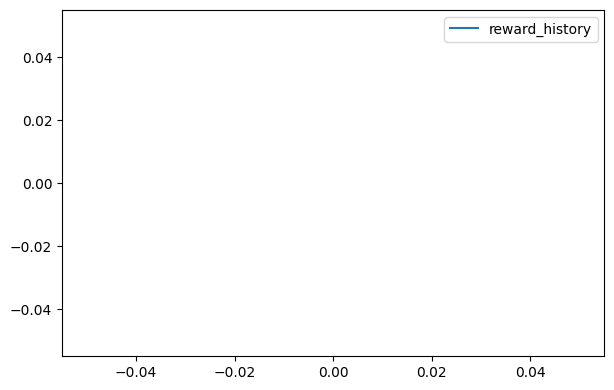

In [32]:
fig = plt.figure(figsize=(7, 4.5))
ax = fig.add_subplot(111)
ax.plot(running_reward_history, label=f"reward_history")
ax.legend()
plt.show()

# test play

In [33]:
env = MoveTheBoxGameEnvironment()

In [34]:
env.reset()

temp_board_history = []
move_history = []
score_history = []
move_index = env.findAllMove()
for i in range(1, max_steps_per_episode):
    temp_board = env.getGameState()
    state = torch.tensor([[temp_board]], dtype=torch.float, device=device)
    with torch.no_grad():
        action = policy_net(state).max(1)[1].view(1, 1)

    move_history_str = (
        f"move {i+1} : move from {move_index[action,0,:]} to {move_index[action,1,:]}"
    )
    _, round_score, is_gameover = env.move(move_index[action])
    score_history.append(round_score)
    temp_board_history.append(temp_board)
    move_history.append(move_history_str)
    if is_gameover:
        break

## animation

In [35]:
def animate(i):
    temp_board = temp_board_history[i]
    ax.clear()
    ax.pcolor(
        temp_board,
        cmap=env.box_color_map,
        vmin=0,
        vmax=env.unique_box_type,
        edgecolors="k",
        linewidth=2,
    )
    xticks_label = np.arange(0, env.board_width, 1)
    yticks_label = np.arange(0, env.board_height + 1, 1)
    # centering of call
    ax.set_xticks(xticks_label + 0.5, minor=False)
    ax.set_yticks(yticks_label + 0.5, minor=False)
    # label
    yticks_label = yticks_label.astype(np.str_)
    yticks_label[-1] = "top"
    ax.set_xticklabels(xticks_label)
    ax.set_yticklabels(yticks_label)
    ax.set_title(
        move_history[i]
        + f"\n total score : {np.sum(score_history[:i],dtype=int)}, round score : {score_history[i]}"
    )

In [36]:
fig = plt.figure(figsize=(3.5, 4.5))
ax = fig.add_subplot(111)
plt.close(fig)

ani = FuncAnimation(
    fig,
    animate,
    frames=len(temp_board_history),
    interval=500,
    repeat=False,
)

HTML(ani.to_jshtml())

In [37]:
from matplotlib.animation import PillowWriter

In [38]:
save_ani = False

In [39]:
# Save the animation as an animated GIF
if save_ani:
    ani.save("policy_play_animation.gif", dpi=300, writer=PillowWriter(fps=1))